AIML MINI PROJECT 

## Importing Necessary Libraries

In [2]:
import os
import cv2
import geocoder
import requests 
%matplotlib inline
import pandas as pd
from twilio.rest import Client
from geopy.geocoders import Nominatim
from keras.preprocessing import image
import numpy as np
import keras.utils
from matplotlib import pyplot as plt
from skimage.transform import resize
import math
k=14


## Loading dataset 

In [3]:
count =0
video="Accidents.mp4"
capture=cv2.VideoCapture(video)
frameRate=capture.get(5)
x=1
while(capture.isOpened()):
    frameId=capture.get(1)
    ret,frame=capture.read()
    if(ret!=True):
        break
    if(frameId%math.floor(frameRate)==0):
        filename="%d.jpg"%count;count+=1
        cv2.imwrite(filename,frame)
capture.release()
print("Done")

Done


In [4]:
data=pd.read_csv('mapping.csv')
data.tail()

,Image_ID,Class
217,217.jpg,1
218,218.jpg,1
219,219.jpg,1
220,220.jpg,1
221,221.jpg,1


In [5]:
X=[]
for img_name in data.Image_ID:
    img=plt.imread(''+img_name)
    X.append(img)
X=np.array(X)

In [6]:
y=data.Class
dummy_y=keras.utils.to_categorical(y)

In [7]:
image=[]
for i in range(0,X.shape[0]):
    a=resize(X[i],preserve_range=True,output_shape=(224,224)).astype(int)
    image.append(a)
X=np.array(image)

## Importing VGG 16 Model

In [8]:
from keras.applications.vgg16 import preprocess_input
X = preprocess_input(X,data_format=None)

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X, dummy_y, test_size=0.3, random_state=42)

In [10]:
from keras.models import Sequential
from keras.applications.vgg16 import VGG16
from keras.layers import Dense,InputLayer,Dropout,BatchNormalization

In [11]:
model= VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3))

In [12]:
X_train=model.predict(X_train)
X_valid=model.predict(X_valid)
X_train.shape,X_valid.shape

5/5 ━━━━━━━━━━━━━━━━━━━━ 18s 3s/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step


((155, 7, 7, 512), (67, 7, 7, 512))

In [13]:
X_train=X_train.reshape(155, 7*7*512)
X_valid=X_valid.reshape(67, 7*7*512)

In [14]:
X_train =X_train/X_train.max() # centering the data
X_valid = X_valid/X_train.max()

## Defining The CNN Model

In [15]:
model_1 = Sequential()
model_1.add(InputLayer ((7*7*512,))) # input layer
model_1.add(Dense(units=1024, activation='sigmoid')) # hidden Layer
model_1.add(BatchNormalization()) 
model_1.add(Dense(2, activation ='softmax')) # output layer

In [16]:
model_1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 1024)           │    25,691,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │         2,050 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,697,282 (98.03 MB)

 Trainable params: 25,695,234 (98.02 MB)

 Non-trainable params: 2,048 (8.00 KB)

## Model Training

In [17]:
model_1.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [18]:
history=model_1.fit(X_train, y_train, epochs = 30, validation_data=(X_valid, y_valid))

Epoch 1/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 606ms/step - accuracy: 0.5788 - loss: 3.7221 - val_accuracy: 0.7015 - val_loss: 6.2625
Epoch 2/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 549ms/step - accuracy: 0.8567 - loss: 2.6105 - val_accuracy: 0.6716 - val_loss: 5.6233
Epoch 3/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 546ms/step - accuracy: 0.8944 - loss: 1.1522 - val_accuracy: 0.7015 - val_loss: 4.5889
Epoch 4/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 574ms/step - accuracy: 0.9407 - loss: 0.9201 - val_accuracy: 0.7015 - val_loss: 3.3316
Epoch 5/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 543ms/step - accuracy: 0.9402 - loss: 0.6162 - val_accuracy: 0.7164 - val_loss: 2.3569
Epoch 6/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 545ms/step - accuracy: 0.9754 - loss: 0.0655 - val_accuracy: 0.7015 - val_loss: 1.8989
Epoch 7/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 605ms/step - accuracy: 0.9697 - loss: 0.1065 - val_accuracy: 0.7164 - val_loss: 1.8530
Epoch 8/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 566ms/step - accuracy: 0.9610 - loss: 0.0652 - val_accuracy: 0.6716 - val_loss:

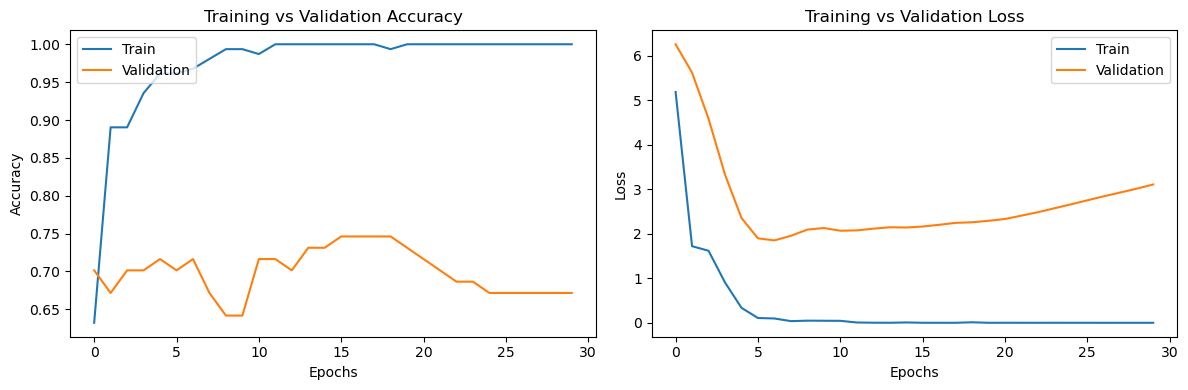

In [19]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.tight_layout()
plt.show()

## Initialising geocoder, twilio and firebase

In [20]:
geoLoc = Nominatim(user_agent="GetLoc")
g = geocoder.ip('me')
locname = geoLoc.reverse(g.latlng)
account_sid = 'AC6ecdbb83876aa3082d08b19a05e77d06'
auth_token = 'b8d22947ca0ec89672c3287249f1dd9c'
client = Client(account_sid, auth_token)

In [21]:
import firebase_admin
from firebase_admin import db, credentials

In [22]:
# authenticate to firebase
cred = credentials.Certificate(r"C:\Users\Sreejith\Downloads\AIML_Project\crash-detection-74a74-firebase-adminsdk-twcpk-b3cf5b9912.json")
firebase_admin.initialize_app(cred, {"databaseURL": "https://crash-detection-74a74-default-rtdb.firebaseio.com/"})

In [23]:
# creating reference to root node
ref = db.reference("/")

In [45]:
# retrieving data from root node
ref.get()

{'Data': {'Entry-0': {'Accident Status': 'Detected!',
   'Date': '23-4-2024',
   'Location': 'Thiruvarur, Thiruvarur District, Tamil Nadu, 610001, India',
   'Message status': 'Message has been sent',
   'Time': '20:29:24'},
  'Entry-1': {'Accident Status': 'Detected!',
   'Date': '23-4-2024',
   'Location': 'Thiruvarur, Thiruvarur District, Tamil Nadu, 610001, India',
   'Message status': 'Message has been sent',
   'Time': '20:29:55'},
  'Entry-10': {'Accident Status': 'Detected!',
   'Date': '24-4-2024',
   'Location': 'Kallakurichi, Kallakkurichi, Kallakurichi District, Tamil Nadu, 606200, India',
   'Message status': 'Message has been sent',
   'Time': '11:16:54'},
  'Entry-11': {'Accident Status': 'Detected!',
   'Date': '24-4-2024',
   'Location': 'Kallakurichi, Kallakkurichi, Kallakurichi District, Tamil Nadu, 606200, India',
   'Message status': 'Message has been sent',
   'Time': '11:17:52'},
  'Entry-12': {'Accident Status': 'Detected!',
   'Date': '20-5-2024',
   'Location'

In [25]:
import datetime as dt
now= dt.datetime.now()
date=str(now.day)+'-'+str(now.month)+'-'+str(now.year)
time=str(now.hour)+':'+str(now.minute)+':'+str(now.second)
print(time)

9:13:40


## Testing

## Accident

In [26]:
count = 0
videoFile = "Accident-1.mp4"
cap = cv2.VideoCapture(videoFile)
frameRate = cap.get(5) #frame rate
x=1
while(cap.isOpened()):
    frameId = cap.get(1) #current frame number
    ret, frame = cap.read()
    if (ret != True):
        break
    if (frameId % math.floor(frameRate) == 0):
        filename ="test%d.jpg" % count;count+=1
        cv2.imwrite(filename, frame)
cap.release()
print ("Done!")

Done!


In [27]:
test=pd.read_csv('test.csv')
test.head

<bound method NDFrame.head of     Image_ID
0  test0.jpg
1  test1.jpg
2  test2.jpg
3  test3.jpg
4  test4.jpg
5  test5.jpg
6  test6.jpg
7  test7.jpg
8  test8.jpg>

In [28]:
test_image=[]
for img_name in test.Image_ID:
    img=plt.imread(''+img_name)
    test_image.append(img)
test_img = np.array(test_image)
test_img.shape

(9, 1080, 2400, 3)

In [29]:
test_image=[]
for i in range(0,test_img.shape[0]):
    a=resize(test_img[i],preserve_range=True,output_shape=(224,224)).astype(int)
    test_image.append(a)
test_image=np.array(test_image)
print(test_image.shape)

(9, 224, 224, 3)


In [30]:
test_image= preprocess_input(test_image,data_format=None)
test_image=model.predict(test_image)
test_image.shape

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 813ms/step


(9, 7, 7, 512)

In [31]:
test_image = test_image.reshape(9, 7*7*512)

# zero centered images
test_image = test_image/test_image.max()

In [32]:
predictions = model_1.predict(test_image)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


In [54]:
for i in range (0,9):
    if predictions[i][0]<predictions[i][1]:
        print("No Accident")
    else:
        print("Accident")

No Accident
No Accident
No Accident
No Accident
No Accident
Accident
Accident
Accident
Accident


In [52]:
cap = cv2.VideoCapture('Accident-1.mp4')
i=0
flag=0
import datetime as dt
while(True):
    ret,frame=cap.read()
    if ret==True:
        if predictions[int(i/15)%9][0]<=predictions[int(i/15)%9][1]:
            predict="No Accident"
        else:
            predict="Accident"
            flag=1
        font = cv2.FONT_HERSHEY_SIMPLEX
        cv2.putText(frame,predict,(50, 50),font, 1,(0, 255, 255),3,cv2.LINE_4)
        cv2.imshow('Frame', frame)
        i=i+1
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    else:
        break
if flag==1:
    now= dt.datetime.now()
    date=str(now.day)+'-'+str(now.month)+'-'+str(now.year)
    time=str(now.hour)+':'+str(now.minute)+':'+str(now.second)
    client.messages.create(
                 body="Accident detected in "+locname.address,
                 from_= '+16562285418',to= '+919342414971' )
    db.reference("/Data").update({"Entry"+'-'+str(k): ''})
    db.reference("/Data/Entry"+'-'+str(k)).update({"Location":locname.address})
    db.reference("/Data/Entry"+'-'+str(k)).update({"Accident Status":"Detected!"})
    db.reference("/Data/Entry"+'-'+str(k)).update({"Date":date})
    db.reference("/Data/Entry"+'-'+str(k)).update({"Time":time})
    db.reference("/Data/Entry"+'-'+str(k)).update({"Message status":"Message has been sent"})
    k+=1
    

# release the cap object
cap.release()
# close all windows
cv2.destroyAllWindows()

ConnectionError: HTTPSConnectionPool(host='api.twilio.com', port=443): Max retries exceeded with url: /2010-04-01/Accounts/AC6ecdbb83876aa3082d08b19a05e77d06/Messages.json (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x000001AC4C70D8D0>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed'))

## No Accident

In [34]:
cnt=0
video_file2='traffic_.mp4'
cap=cv2.VideoCapture(video_file2)
frameRate=cap.get(3)
X=1
while(cap.isOpened()):
    frameId=cap.get(1)
    ret,frame=cap.read()
    if(ret!=True):
        break
    if(frameId%math.floor(frameRate) == 0):
        filename="test%d.jpg"%cnt;cnt+=1
        cv2.imwrite(filename,frame)
cap.release
print("Done")

Done


In [35]:
test=pd.read_csv('test.csv')
test.head

<bound method NDFrame.head of     Image_ID
0  test0.jpg
1  test1.jpg
2  test2.jpg
3  test3.jpg
4  test4.jpg
5  test5.jpg
6  test6.jpg
7  test7.jpg
8  test8.jpg>

In [36]:
test_image=[]
for img_name in test.Image_ID:
    img=plt.imread(''+img_name)
    test_image.append(img)
test_img = np.array(test_image)
test_img.shape

(9, 1080, 2400, 3)

In [37]:
test_image=[]
for i in range(0,test_img.shape[0]):
    a=resize(test_img[i],preserve_range=True,output_shape=(224,224)).astype(int)
    test_image.append(a)
test_image=np.array(test_image)
print(test_image.shape)

(9, 224, 224, 3)


In [38]:
test_image= preprocess_input(test_image,data_format=None)
test_image=model.predict(test_image)
test_image.shape

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 904ms/step


(9, 7, 7, 512)

In [39]:
test_image = test_image.reshape(9, 7*7*512)

# zero centered images
test_image = test_image/test_image.max()

In [40]:
predictions = model_1.predict(test_image)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


In [41]:
for i in range (0,9):
    if predictions[i][0]!=predictions[i][1]:
        print("No Accident")
    else:
        print("Accident")

No Accident
No Accident
No Accident
No Accident
No Accident
No Accident
No Accident
No Accident
No Accident


In [50]:
cap = cv2.VideoCapture('traffic-27260.mp4')
i=0
flag=0
import datetime as dt
while(True):
    ret,frame=cap.read()
    if ret==True:
        if predictions[int(i/100)%9][0]<predictions[int(i/100)%9][1]:
            predict="No Accident"
        else:
            predict="Accident"
            flag=1
        font = cv2.FONT_HERSHEY_SIMPLEX
        cv2.putText(frame,predict,(50, 50),font, 1,(0, 255, 255),3,cv2.LINE_4)
        cv2.imshow('Frame', frame)
        i=i+1
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    else:
        break
        
if flag==1:
    now= dt.datetime.now()
    date=str(now.day)+'-'+str(now.month)+'-'+str(now.year)
    time=str(now.hour)+':'+str(now.minute)+':'+str(now.second)
    client.messages.create(
                 body="Accident detected in "+locname.address,
                 from_= '+16562285418',to= '+919342414971' )
    # db.reference("/Data").update({"Entry"+'-'+str(k): ''})
    # db.reference("/Data/Entry"+'-'+str(k)).update({"Location":locname.address})
    # db.reference("/Data/Entry"+'-'+str(k)).update({"Accident Status":"Detected!"})
    # db.reference("/Data/Entry"+'-'+str(k)).update({"Date":date})
    # db.reference("/Data/Entry"+'-'+str(k)).update({"Time":time})
    # db.reference("/Data/Entry"+'-'+str(k)).update({"Message status":"Message has been sent"})
    # k+=1
    
# release the cap object
cap.release()
# close all windows
cv2.destroyAllWindows()